#Computer Vision Problem

To write a python script classifying the given unknown dataset. The given dataset has 4 classes given in the data label.

## Importing required libraries

In [0]:
import numpy as np
import pickle as pk
import os
import datetime
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
import keras.backend as K
K.set_image_data_format('channels_last')
%matplotlib inline
import matplotlib.pyplot as plt

# Deep Learning Libraries
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from keras.regularizers import l1,l2,l1_l2
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import categorical_crossentropy
from keras import callbacks

## Setting up Directory Variables and Random Seeds

Defining directory variables for neat and generic usabilty of code. Setting common seed for reproducability.

In [0]:
main_dir = os.getcwd()
data_dir = os.path.join(main_dir,'dataset')

seed = 1000
def seeding(seed=1000):
  np.random.seed(seed)
  tf.set_random_seed(seed)
  random.seed(seed)
  
seeding(seed)

## Preparing dataset object

A class 'data' is defined including related properties and functionallity

In [0]:
class data:
  
  def __init__(self,batch_size=None):
    self.split = {'train':0.7,'val':0.3}
    self.batch_size = {'train':batch_size, 'val':batch_size}
    
    with open(os.path.join(data_dir,'train_image.pkl'),'rb') as f:
      self.training_data_X = np.array(pk.load(f))
    with open(os.path.join(data_dir,'train_label.pkl'),'rb') as f:
      self.training_data_Y = np.array(pk.load(f))
    with open(os.path.join(data_dir,'test_image.pkl'),'rb') as f:
      self.X_test = np.array(pk.load(f))
    
    
    self.id2cell = pd.Series(list(set(self.training_data_Y)))
    self.cell2id = pd.Series(range(len(self.id2cell)), index=self.id2cell)
    self.classes = len(self.id2cell)
    self.training_data_Y =  np.array([self.onehot(y) for y in self.training_data_Y])
    self.X_train,self.X_val,self.Y_train,self.Y_val = train_test_split(self.training_data_X,self.training_data_Y,random_state=seed,shuffle=True,test_size=self.split['val'])
    
    self.validation_steps = self.X_val.shape[0]//self.batch_size['val'] 
    self.steps_per_epoch = self.X_train.shape[0]//self.batch_size['train']
      
  def onehot(self,y):
        zeros = np.zeros(self.classes, 'uint8')
        zeros[self.cell2id[y]] = 1 
        return zeros
    

## Creating Data Object & Checking Data Shape

In [4]:
d = data(batch_size=128) 

print('the file \'train_image.pkl\' file has ',d.training_data_X.shape[0],' datapoints')
print('the file \'test_image.pkl\' file has ',d.X_test.shape[0],' datapoints')
print('Input Training split shape: ', d.X_train.shape)
print('Input Validation split shape: ', d.X_val.shape)
print('Input Testing split shape: ', d.X_test.shape)

the file 'train_image.pkl' file has  8000  datapoints
the file 'test_image.pkl' file has  2000  datapoints
Input Training split shape:  (5600, 784)
Input Validation split shape:  (2400, 784)
Input Testing split shape:  (2000, 784)


## Visualizing the image data

Since every data point is of a perfect square size vector, let us try reshaping them and visualizing them.

<Figure size 432x288 with 0 Axes>

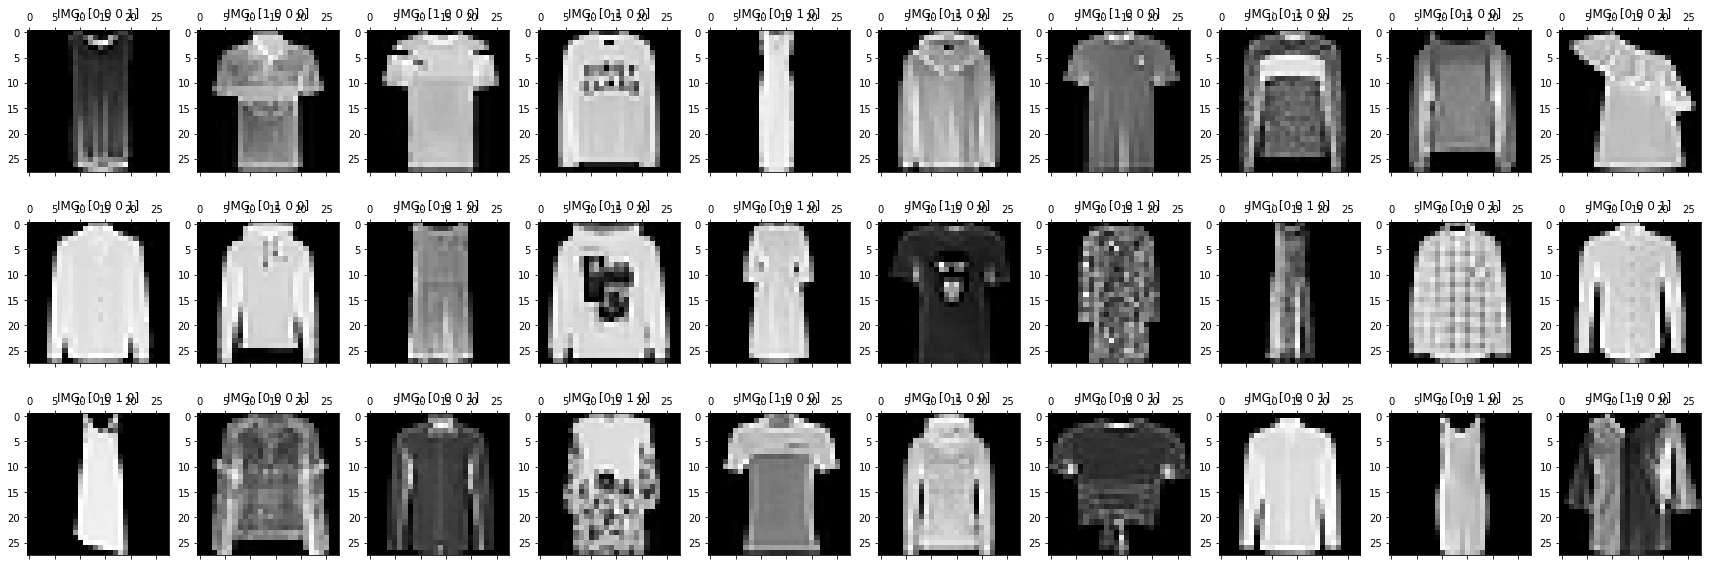

In [5]:
plt.gray()
fig = plt.figure(figsize=(30,10))
for i in range(0,30):
    f = fig.add_subplot(3,10,i+1, title='IMG: ' + str(d.Y_train[i]) )
    f.matshow(d.X_train[i].reshape((28,28)).astype(float))
plt.show()

##Reshaping all input numpy arrays as (?,28,28)
Since the images ploted make sense, we can now reshape all image's array to a (?x28x28) vector

In [0]:
d.X_train, d.X_val, d.X_test = [tr.reshape(-1,28,28,1) for tr in [d.X_train, d.X_val, d.X_test]]

## Data Augmentation
The data is augmented and a generator is defined. The augmentations applied are rotation, zooming, shearing, shifting and vertical fliping.

In [0]:
seeding()
datagen = ImageDataGenerator(
          rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
          zoom_range = 0.09, # Randomly zoom image 
          shear_range = 0.3, # shear angle in counter-clockwise direction in degrees  
          width_shift_range=0.075,  # randomly shift images horizontally (fraction of total width)
          height_shift_range=0.075, # randomly shift images vertically (fraction of total height)
          vertical_flip=True)  # randomly flip images

datagen.fit(d.X_train)

## Convolutional Neural Net Models
Here, the deep learning models will be developed. The following are the resultant models after tunning by trial and error.

---


### Callbacks Setup

In [0]:
DT = None
callback = None

def define_chkpoints_with_latest_DT_stamp():
  global DT 
  DT = datetime.datetime.now().strftime("%m-%d-%H-%M-%S")

  checkpoint1 = callbacks.ModelCheckpoint(os.path.join(main_dir,'model_checkpoint',DT) + "_{epoch:02d}_train_loss.hdf5",
                                             monitor='loss', verbose=0, save_best_only=True,
                                             save_weights_only=False, mode='auto', period=1)

  checkpoint2 = callbacks.ModelCheckpoint(os.path.join(main_dir,'model_checkpoint',DT) + "_{epoch:02d}_train_acc.hdf5",
                                          monitor='acc', verbose=0, save_best_only=True,
                                          save_weights_only=False, mode='auto', period=1)

  checkpoint3 = callbacks.ModelCheckpoint(os.path.join(main_dir,'model_checkpoint',DT) + "_{epoch:02d}_val_loss.hdf5",
                                         monitor='val_loss', verbose=0, save_best_only=True,
                                         save_weights_only=False, mode='auto', period=1)

  checkpoint4 = callbacks.ModelCheckpoint(os.path.join(main_dir,'model_checkpoint',DT) + "_{epoch:02d}_val_acc.hdf5",
                                          monitor='val_acc', verbose=0, save_best_only=True,
                                          save_weights_only=False, mode='auto', period=1)

  tfboard = callbacks.TensorBoard(log_dir=os.path.join(main_dir,'model_checkpoint',DT),
                                      histogram_freq=0, batch_size=d.batch_size['train'],
                                      write_graph=True, write_grads=True, write_images=True,
                                      embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

  global callback 
  callback = [checkpoint1, checkpoint2, checkpoint3, checkpoint4, tfboard]
  
define_chkpoints_with_latest_DT_stamp()

###Function to Plot the Loss-Acc Curves

In [0]:
def plot(run):
  plt.plot(run.history['loss'])
  plt.plot(run.history['val_loss'])
  plt.title("Model Loss")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Val'])
  plt.show()

  plt.plot(run.history['acc'])
  plt.plot(run.history['val_acc'])
  plt.title("Model Accuracy")
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Val'])
  plt.show()

###Model 0:

A small ConvNet Model is created to check how it performs on our data. Dropouts are added for regularization. BatchNormalizations are added to scale down outliers and help the model to generalize the Images in a better way. Adadelta is used as it automatically adapts its learning rates as per the past gradients.

#####Model Definition

In [0]:
def get_model_0(inp_sh):
  inp = Input(inp_sh)
  m = inp
  
#   m = Reshape((-1,28,28,1))(m)
  m = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same')(m)
  m = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same')(m)
  m = BatchNormalization()(m)
  m = Dropout(0.25)(m)
  
  m = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same')(m)
  m = MaxPooling2D(pool_size=(2, 2))(m)
  m = Dropout(0.25)(m)
  
  m = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=1, padding='same')(m)
  m = BatchNormalization()(m)
  m = Dropout(0.25)(m)
  
  m = Flatten()(m)
  m = Dense(512, activation='relu')(m)
  m = BatchNormalization()(m)
  m = Dropout(0.25)(m)
  m = Dense(128, activation='relu')(m)
  m = BatchNormalization()(m)
  m = Dropout(0.25)(m)
  m = Dense(10, activation='relu')(m)
  m = BatchNormalization()(m)
  m = Dropout(0.25)(m)
  m = Dense(4, activation='softmax')(m)
  
  
  optimizer = Adadelta()
  model = Model(inputs=inp, outputs=m)
  model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
  
  print(model.summary())
  return model

#####Model Training

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
__________

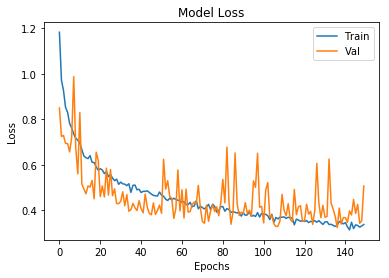

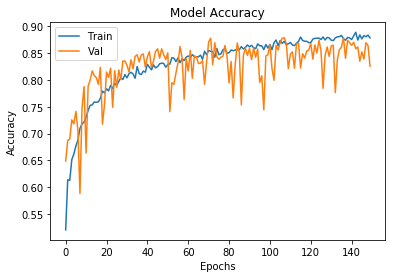

In [0]:
seeding()
define_chkpoints_with_latest_DT_stamp()
model_0 = get_model_0(d.X_train.shape[1:])
try:
  run_0 = model_0.fit_generator(datagen.flow(d.X_train, d.Y_train, batch_size = d.batch_size['train']),
                          epochs=150, callbacks=callback, validation_data=(d.X_val,d.Y_val), 
                          validation_steps=d.validation_steps, steps_per_epoch=d.steps_per_epoch)
finally:
  plot(run_0)

###Model 1:

As per the previous models loss curves, more weights are required to learn relevant features. A better and deeper ConvNet is designed. Elu activation is used here to converge cost to zero faster and produce more accurate results. Elu will help avoid getting trapped and avoids the dying relu problem.

#####Model Definition

In [0]:
def get_model_1(inp_sh):
  inp = Input(inp_sh)
  m = inp
  
# m = Reshape((-1,28,28,1))(m)

  m = Conv2D(filters=32, kernel_size=(2, 2), activation='elu', strides=(1,1), padding='same')(m)
  m = Conv2D(filters=32, kernel_size=(2, 2), activation='elu', strides=(1,1), padding='same')(m)
  m = Conv2D(filters=64, kernel_size=(2, 2), activation='elu', strides=(1,1), padding='same')(m)
  m = BatchNormalization()(m)
  m = Dropout(0.25)(m)
  
  m = Conv2D(filters=64, kernel_size=(3, 3), activation='elu', strides=(1,1), padding='same')(m)
  m = Conv2D(filters=64, kernel_size=(3, 3), activation='elu', strides=(1,1), padding='same')(m)
  m = Conv2D(filters=128, kernel_size=(3, 3), activation='elu', strides=(1,1), padding='same')(m)
  m = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(m) # (14,14)
  m = BatchNormalization()(m)
  m = Dropout(0.25)(m)
  
  m = Conv2D(filters=128, kernel_size=(3, 3), activation='elu', strides=(1,1), padding='same')(m)
  m = Conv2D(filters=128, kernel_size=(3, 3), activation='elu', strides=(1,1), padding='same')(m)
  m = Conv2D(filters=256, kernel_size=(3, 3), activation='elu', strides=(1,1), padding='same')(m)
  m = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(m) # (7,7)
  m = BatchNormalization()(m)
  m = Dropout(0.25)(m)
  
  m = Conv2D(filters=256, kernel_size=(3, 3), activation='elu', strides=(1,1), padding='same')(m)
  m = Conv2D(filters=256, kernel_size=(3, 3), activation='elu', strides=(1,1), padding='same')(m)
  m = Conv2D(filters=512, kernel_size=(3, 3), activation='elu', strides=(1,1), padding='same')(m)
  m = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(m) # (3,3)
  m = BatchNormalization()(m)
  m = Dropout(0.25)(m)
  
  m = Flatten()(m)
  
  m = Dense(1024, activation='elu')(m)
  m = BatchNormalization()(m)
  m = Dropout(0.5)(m)
  
  m = Dense(1024, activation='elu')(m)
  m = BatchNormalization()(m)
  m = Dropout(0.5)(m)
  
  out = Dense(4, activation='softmax')(m)
  
  
  optimizer = Adadelta()
  model = Model(inputs=inp, outputs=out)
  model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
  
  print(model.summary())
  return model

#####Model Training

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 32)        160       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 32)        4128      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 64)        8256      
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
dropout_13 (Dropout)         (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 64)        36928     
__________

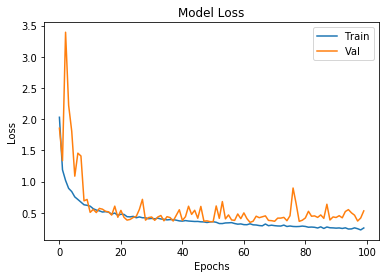

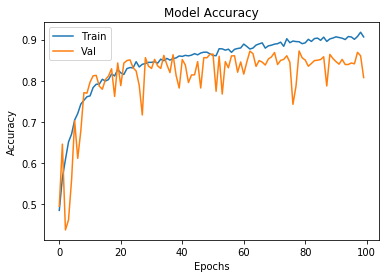

In [0]:
seeding()
define_chkpoints_with_latest_DT_stamp()
model_1 = get_model_1(d.X_train.shape[1:])
try:
  run_1 = model_1.fit_generator(datagen.flow(d.X_train, d.Y_train, batch_size = d.batch_size['train']),
                          epochs=100, callbacks=callback, validation_data=(d.X_val,d.Y_val), 
                          validation_steps=d.validation_steps, steps_per_epoch=d.steps_per_epoch)
finally:
  plot(run_1)

###Model 2:

In this model, convolutional blocks were created and were repeated taking reference from famous ConvNet architectures. Padding was kept same and MaxPooling was used at intervals to reduce dimension size. 

#####Model Definition

In [0]:
def get_model_2(inp_sh):
  inp = Input(inp_sh)
  m = inp
# m = Reshape((-1,28,28,1))(m)

  m = Conv2D(filters=32, kernel_size=(3,3), activation='elu', strides=(1,1), padding='same')(m)
  m = Conv2D(filters=64, kernel_size=(3,3), activation='elu', strides=(1,1), padding='same')(m)
  m = BatchNormalization()(m)
  m = Dropout(0.25)(m)
  
  m = Conv2D(filters=64, kernel_size=(2,2), activation='elu', strides=(1,1), padding='same')(m)
  m = Conv2D(filters=128, kernel_size=(2,2), activation='elu', strides=(1,1), padding='same')(m)
  m = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(m) # (14,14)
  m = BatchNormalization()(m)
  m = Dropout(0.25)(m)
  
  m = Conv2D(filters=128, kernel_size=(3,3), activation='elu', strides=(1,1), padding='same')(m)
  m = Conv2D(filters=256, kernel_size=(3,3), activation='elu', strides=(1,1), padding='same')(m)
  m = BatchNormalization()(m)
  m = Dropout(0.25)(m)
  
  m = Conv2D(filters=256, kernel_size=(2,2), activation='elu', strides=(1,1), padding='same')(m)
  m = Conv2D(filters=512, kernel_size=(2,2), activation='elu', strides=(1,1), padding='same')(m)
  m = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(m) # (7,7)
  m = BatchNormalization()(m)
  m = Dropout(0.25)(m)
  
  m = Conv2D(filters=512, kernel_size=(3,3), activation='elu', strides=(1,1), padding='same')(m)
  m = Conv2D(filters=512, kernel_size=(3,3), activation='elu', strides=(1,1), padding='same')(m)
  m = BatchNormalization()(m)
  m = Dropout(0.25)(m)  
  
  m = Conv2D(filters=1024, kernel_size=(2,2), activation='elu', strides=(1,1), padding='same')(m)
  m = Conv2D(filters=1024, kernel_size=(2,2), activation='elu', strides=(1,1), padding='same')(m)
  m = Conv2D(filters=1024, kernel_size=(2,2), activation='elu', strides=(1,1), padding='same')(m)
  m = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(m) # (3,3)
  m = BatchNormalization()(m)
  m = Dropout(0.25)(m)
  
  m = Flatten()(m)
  
  m = Dense(2048, activation='elu')(m)
  m = BatchNormalization()(m)
  m = Dropout(0.5)(m)
  
  m = Dense(2048, activation='elu')(m)
  m = BatchNormalization()(m)
  m = Dropout(0.5)(m)
  
  m = Dense(512, activation='elu')(m)
  m = BatchNormalization()(m)
  m = Dropout(0.5)(m)
  
  m = Dense(512, activation='elu')(m)
  m = BatchNormalization()(m)
  m = Dropout(0.5)(m)
  
  out = Dense(4, activation='softmax')(m)
  
  
  optimizer = Adadelta()
  model = Model(inputs=inp, outputs=out)
  model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
  
  print(model.summary())
  return model

#####Model Training

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_11 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
dropout_11 (Dropout)         (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 64)        16448     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 128)       32896     
__________

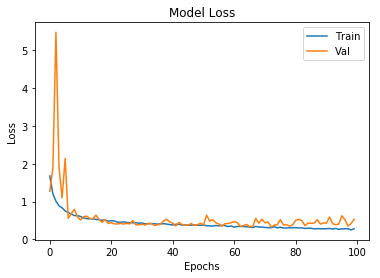

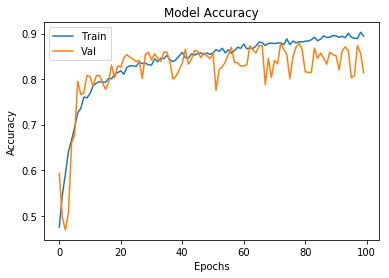

In [0]:
seeding()
define_chkpoints_with_latest_DT_stamp()
model_2 = get_model_2(d.X_train.shape[1:])
try:
  run_2 = model_2.fit_generator(datagen.flow(d.X_train, d.Y_train, batch_size = d.batch_size['train']),
                          epochs=100, callbacks=callback, validation_data=(d.X_val,d.Y_val), 
                          validation_steps=d.validation_steps, steps_per_epoch=d.steps_per_epoch)
finally:
  plot(run_2)

###Model 3:

This model is very much similar to the previous model except a two main changes. 

* The same blocks are used in this model too, but, in the starting blocks Max Pooling is used to extract only high activated outputs (strong features) while in the final block Average Pooling is used to take the average of activations as every activation has come from a strong feature.

* The categorical crossentropy loss function is given exponential values of the Y True and Y Predict. This is done to exponentially raise even the smallest errors/losses. This might help the network find more detailed and accurate features.

#####Model Definition

In [0]:
def exp_categorical_crossentropy(yTrue, yPred):
  loss = categorical_crossentropy(K.exp(yTrue), K.exp(yPred))
  return loss

def get_model_3(inp_sh):
  inp = Input(inp_sh)
  m = inp
# m = Reshape((-1,28,28,1))(m)

  m = Conv2D(filters=32, kernel_size=(3,3), activation='elu', strides=(1,1), padding='same')(m)
  m = Conv2D(filters=64, kernel_size=(3,3), activation='elu', strides=(1,1), padding='same')(m)
  m = BatchNormalization()(m)
  m = Dropout(0.25)(m)
  
  m = Conv2D(filters=64, kernel_size=(2,2), activation='elu', strides=(1,1), padding='same')(m)
  m = Conv2D(filters=128, kernel_size=(2,2), activation='elu', strides=(1,1), padding='same')(m)
  m = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(m) # (14,14)
  m = BatchNormalization()(m)
  m = Dropout(0.25)(m)
  
  m = Conv2D(filters=128, kernel_size=(3,3), activation='elu', strides=(1,1), padding='same')(m)
  m = Conv2D(filters=256, kernel_size=(3,3), activation='elu', strides=(1,1), padding='same')(m)
  m = BatchNormalization()(m)
  m = Dropout(0.25)(m)
  
  m = Conv2D(filters=256, kernel_size=(2,2), activation='elu', strides=(1,1), padding='same')(m)
  m = Conv2D(filters=512, kernel_size=(2,2), activation='elu', strides=(1,1), padding='same')(m)
  m = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(m) # (7,7)
  m = BatchNormalization()(m)
  m = Dropout(0.25)(m)
  
  m = Conv2D(filters=512, kernel_size=(3,3), activation='elu', strides=(1,1), padding='same')(m)
  m = Conv2D(filters=512, kernel_size=(3,3), activation='elu', strides=(1,1), padding='same')(m)
  m = Conv2D(filters=512, kernel_size=(3,3), activation='elu', strides=(1,1), padding='same')(m)
  m = BatchNormalization()(m)
  m = Dropout(0.25)(m)  
  
  m = Conv2D(filters=1024, kernel_size=(2,2), activation='elu', strides=(1,1), padding='same')(m)
  m = Conv2D(filters=1024, kernel_size=(2,2), activation='elu', strides=(1,1), padding='same')(m)
  m = Conv2D(filters=1024, kernel_size=(2,2), activation='elu', strides=(1,1), padding='same')(m)
  m = AveragePooling2D(pool_size=(2, 2), strides=(2,2))(m) # (3,3)
  m = BatchNormalization()(m)
  m = Dropout(0.25)(m)
  
  m = Flatten()(m)
  
  m = Dense(2048, activation='elu')(m)
  m = BatchNormalization()(m)
  m = Dropout(0.5)(m)
  
  m = Dense(2048, activation='elu')(m)
  m = BatchNormalization()(m)
  m = Dropout(0.5)(m)
  
  m = Dense(512, activation='elu')(m)
  m = BatchNormalization()(m)
  m = Dropout(0.5)(m)
  
  m = Dense(512, activation='elu')(m)
  m = BatchNormalization()(m)
  m = Dropout(0.5)(m)
  
  out = Dense(4, activation='softmax')(m)
  
  
  optimizer = Adadelta()
  model = Model(inputs=inp, outputs=out)
  model.compile(optimizer=optimizer, loss=exp_categorical_crossentropy, metrics=["accuracy"])
  
  print(model.summary())
  return model

#####Model Training

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        16448     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)       32896     
__________

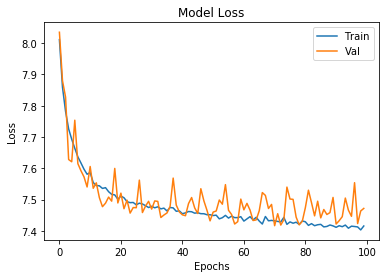

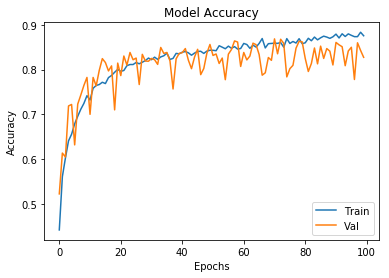

In [0]:
seeding()
define_chkpoints_with_latest_DT_stamp()
model_3 = get_model_3(d.X_train.shape[1:])
try:
  run_3 = model_3.fit_generator(datagen.flow(d.X_train, d.Y_train, batch_size = d.batch_size['train']),
                          epochs=100, callbacks=callback, validation_data=(d.X_val,d.Y_val), 
                          validation_steps=d.validation_steps, steps_per_epoch=d.steps_per_epoch)
finally:  
  plot(run_3)

---
The Final best checkpoints as per the accuracy loss curves are:
---

Comparing the Training and Validation loss curves the optimum point before which the model starts overfitting is selected.

* Model 0 :  at epoch 143
  * Train: 88.85% (loss 0.3145)
  * Valid: 85.79% (loss 0.3971)
* Model 1 :  at epoch 63
  * Train: 87.68% (loss 0.3250)
  * Valid: 87.21% (loss 0.3471)
* Model 2 : at epoch 67
  * Train: 88.01% (loss 0.3152)
  * Valid: 87.33% (loss 0.3390)
* Model 3 : at epoch 79
  * Train: 86.92% (loss 7.4209)
  * Valid: 86.33% (loss 7.4195)
  

###Restoring the above models with weights at the required epoch checkpoints

In [37]:
def restore_model(filename,model_num):
  if model_num == 0:
    model = get_model_0(d.X_train.shape[1:])
  elif model_num == 1:
    model = get_model_1(d.X_train.shape[1:])
  elif model_num == 2:
    model = get_model_2(d.X_train.shape[1:])
  elif model_num == 3:
    model = get_model_3(d.X_train.shape[1:])
  model.load_weights(os.path.join(main_dir,'model_checkpoint',filename))
  loss,acc = model.evaluate(d.X_train,d.Y_train)
  print("Restored ", model_num, ", training accuracy: {:5.2f}%".format(100*acc))
  loss,acc = model.evaluate(d.X_val,d.Y_val)
  print("Restored ", model_num, ", validation accuracy: {:5.2f}%".format(100*acc))
  return model

model0 = restore_model('04-04-06-26-55_143_train_loss.hdf5',0)
model1 = restore_model('04-04-07-39-34_63_val_loss.hdf5',1)
model2 = restore_model('04-04-15-24-17_67_val_loss.hdf5',2)
model3 = restore_model('04-05-07-50-35_79_train_loss.hdf5',3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_47 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
dropout_49 (Dropout)         (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 64)        0         
__________

###Ensemble the outputs of the 4 models to get the best results
The function ensemble_Y() will create the ensembled Y result by averaging the 4 model's probability vectors outputs (onehots before argmax)

In [0]:
def ensemble_Y(X):
  Y0 = model0.predict(X,verbose=1,batch_size=d.batch_size['train'])
  Y1 = model1.predict(X,verbose=1,batch_size=d.batch_size['train'])
  Y2 = model2.predict(X,verbose=1,batch_size=d.batch_size['train'])
  Y3 = model3.predict(X,verbose=1,batch_size=d.batch_size['train'])
  ens_Y = np.array(list(map(d.id2cell.get,np.argmax((Y0+Y1+Y2+Y3)/4,axis=1))))
  return ens_Y

In [107]:
Y_Pred = ensemble_Y(d.training_data_X.reshape(-1,28,28,1))
Y_True = np.array(list(map(d.id2cell.get,np.argmax(d.training_data_Y,axis=1))))
print("\n\nEnsembled complete training and validation data accuracy: {:5.2f}%".format(100*accuracy_score(Y_True,Y_Pred)))

8000/8000 [==============================] - 46s 6ms/step


Ensembled complete training and validation data accuracy: 91.07%


##Create CSV of Test Files

###Function to create csv in data directory with the name "submission.csv"

In [0]:
def create_csv():
  sample_csv =  pd.read_csv(os.path.join(data_dir,'hitkul(sample_submission).csv'))
  d.Y_test = ensemble_Y(d.X_test)
  data = {'image_index':list(range(d.X_test.shape[0])),'class':d.Y_test}
  new_csv = pd.DataFrame(data=data,columns=sample_csv.columns)
  new_csv.to_csv(os.path.join(data_dir,'submission.csv'),index=False)
  print(new_csv)

In [109]:
create_csv()

2000/2000 [==============================] - 11s 6ms/step
      image_index  class
0               0      0
1               1      0
2               2      0
3               3      0
4               4      0
5               5      0
6               6      0
7               7      0
8               8      0
9               9      0
10             10      0
11             11      0
12             12      6
13             13      0
14             14      0
15             15      0
16             16      0
17             17      0
18             18      0
19             19      0
20             20      0
21             21      0
22             22      0
23             23      0
24             24      0
25             25      0
26             26      0
27             27      0
28             28      0
29             29      0
...           ...    ...
1970         1970      6
1971         1971      0
1972         1972      6
1973         1973      0
1974         1974      0
1975         1975